<a href="https://colab.research.google.com/github/kdwilli/sandy-settlement/blob/main/Implementation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of NN for settlement of foundations on sandy soils
# based on DOI: https://doi.org/10.12989/gae.2020.20.5.385

In [ ]:
# Initial Architecture:
# 5 inputs, 1 hidden layer with 2 neurons, a sigmoid activation function, and 1 output

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class SandSettleNN(nn.Module):
    def __init__(self, num_inputs=5, num_hidden_layers=1, width=2, activation=nn.Sigmoid(), optimizer_class=optim.Adam, **optimizer_params):
        super().__init__()

        layers = []
        layers.append(nn.Linear(num_inputs, width))

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(activation)

        layers.append(nn.Linear(width, 1))

        self.net = nn.Sequential(*layers)
        self.optimizer = optimizer_class(self.parameters(), **optimizer_params)


    def forward(self, x):
        return self.net(x)

In [ ]:
# Data
# From paper, experimentally determined.
# used 80-20 split for training and testing
# data was normalized to [0,1] using the following function: x_norm = (x-min(x))/(max(x)-min(x))

# setup a 5 by 5 array for input data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# input statistics from the paper
data = {'Parameter Used': ['Nc', 'B (m)', 'L/B', 'Df/B', 'qnet (kPa)'],
        'Minimum': [4, 0.8, 1, 0, 18.32],
        'Maximum': [60, 255, 10.6, 3.44, 1532],
        'Mean (μ)': [24.58, 9.82, 2.19, 0.53, 194.31],
        'Std. (σ)': [13.53, 20.48, 1.8, 0.58, 157.35]}
input_stats = pd.DataFrame(data)

data = {'Parameter Used': ['Sc'],
        'Minimum': [3.3],
        'Maximum': [103.4],
        'Mean (μ)': [20.2],
        'Std. (σ)': [26.1]}
output_stats = pd.DataFrame(data)

# Note: Sc in [mm], qnet in [kPa], B in [meters], Df in [meters]

# Generate 180 sets of data and normalize

num_samples = 180
input_data = {}

for index, row in input_stats.iterrows():
    param_name = row['Parameter Used']
    min_val = row['Minimum']
    max_val = row['Maximum']
    mean_val = row['Mean (μ)']
    std_val = row['Std. (σ)']

    # Generate data from a normal distribution and clip to min/max range
    generated_values = np.random.normal(mean_val, std_val, num_samples)
    input_data[param_name] = np.clip(generated_values, min_val, max_val)

# Create a DataFrame from the generated data
input_df = pd.DataFrame(input_data)

# Normalize the input data
normalized_input_data = {}
for index, row in input_stats.iterrows():
    param_name = row['Parameter Used']
    min_val = row['Minimum']
    max_val = row['Maximum']
    original_values = input_df[param_name]
    normalized_values = (original_values - min_val) / (max_val - min_val)
    normalized_input_data[param_name] = normalized_values

normalized_input_df = pd.DataFrame(normalized_input_data)

# Generate and normalize output data (Sc)
output_data = {}
for index, row in output_stats.iterrows():
    param_name = row['Parameter Used']
    min_val = row['Minimum']
    max_val = row['Maximum']
    mean_val = row['Mean (μ)']
    std_val = row['Std. (σ)']

    generated_values = np.random.normal(mean_val, std_val, num_samples)
    output_data[param_name] = np.clip(generated_values, min_val, max_val)

output_df = pd.DataFrame(output_data)

normalized_output_data = {}
for index, row in output_stats.iterrows():
    param_name = row['Parameter Used']
    min_val = row['Minimum']
    max_val = row['Maximum']
    original_values = output_df[param_name]
    normalized_values = (original_values - min_val) / (max_val - min_val)
    normalized_output_data[param_name] = normalized_values

normalized_output_df = pd.DataFrame(normalized_output_data)

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(normalized_input_df, normalized_output_df, test_size=0.2, random_state=42)

# Display the first few rows of the normalized input and output data
display(normalized_input_df.head())
display(normalized_output_df.head())

#pytorch training data
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

,Nc,B (m),L/B,Df/B,qnet (kPa)
0,0.261332,0.000000,0.232867,0.511553,0.059341
1,0.464926,0.167657,0.000000,0.000000,0.196973
2,0.463770,0.027370,0.311448,0.001043,0.157559
3,0.503784,0.000000,0.395526,0.247389,0.129507
4,0.340804,0.000000,0.199327,0.261399,0.024379


,Sc
0,0.000000
1,0.385125
2,0.000000
3,0.507810
4,0.000000


In [ ]:
# Empirical methods for comparison
# Schultze and Sherif
# Sc = (qnet*Fc)/(N^0.87*(1+0.4*(Df/B)))

def schultze_sherif(qnet, N, Df_B, Fc=1):
    """
    Calculates settlement using the Schultze and Sherif method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        Df_B (float): Depth of embedment to footing width ratio (Df/B).
        Fc (float): Correction factor (default is 1).

    Returns:
        float: Calculated settlement (Sc).
    """
    Sc = (qnet * Fc) / (N**0.87 * (1 + 0.4 * Df_B))
    return Sc

# Meyerhof
# Sc = (1.33*qnet/N)*(1-(Df/B))

def meyerhof(qnet, N, Df_B):
    """
    Calculates settlement using the Meyerhof method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        Df_B (float): Depth of embedment to footing width ratio (Df/B).

    Returns:
        float: Calculated settlement (Sc).
    """
    Sc = (1.33 * qnet / N) * (1 - Df_B)
    return Sc


# Anagnostopoulus
# for 0<N<=10, Sc=(0.57*q^0.94*B^0.90)/N^0.87
# for 10<N<=30, Sc=(0.35*q^1.01*B^0.69)/N^0.94
# for N>30, Sc=(604*q^0.90*B^0.76)/N^2.82
# for B<=3 Sc=(1.90*q^0.77*B^0.45)/N^1.08
# for B>3 Sc=(1.64*q^1.02*B^0.59)/N^1.37

def anagnostopoulus(qnet, N, B):
    """
    Calculates settlement using the Anagnostopoulus method.

    Args:
        qnet (float): Net foundation pressure (kPa).
        N (float): SPT N-value.
        B (float): Footing width (m).

    Returns:
        float: Calculated settlement (Sc).
    """
    if 0 < N <= 10:
        Sc = (0.57 * qnet**0.94 * B**0.90) / N**0.87
    elif 10 < N <= 30:
        Sc = (0.35 * qnet**1.01 * B**0.69) / N**0.94
    elif N > 30:
        Sc = (604 * qnet**0.90 * B**0.76) / N**2.82
    # Assuming the last two conditions for B are independent of N ranges
    elif B <= 3:
        Sc = (1.90 * qnet**0.77 * B**0.45) / N**1.08
    elif B > 3:
        Sc = (1.64 * qnet**1.02 * B**0.59) / N**1.37
    else:
        Sc = None  # Handle cases outside the defined ranges
        print("Warning: N or B value outside defined ranges for Anagnostopoulus method.")
    return Sc

In [ ]:
from __future__ import print_function
# Models
# run models with different optimizers, record RMSE, MAE, and R^2 loss
# obtain loss from comparing results to each of the three empirical equations

# run with 1000 epochs

import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

learn_rate = 0.01
epochs = 1000

optimizers_to_test = [optim.SGD, optim.Adam, optim.Adadelta, optim.Adagrad, optim.LBFGS]
optimizer_names = ["SGD", "Adam", "Adadelta", "Adagrad", "LBFGS"]
loss_history = {name: [] for name in optimizer_names}
rmse_results = {}
mae_results = {}
r2_results = {}


for i in range(len(optimizers_to_test)):
    print(f"testing optimizer: {optimizer_names[i]}")
    model = SandSettleNN(num_inputs=5, num_hidden_layers=1, width=2, activation=nn.Sigmoid(),
                         optimizer_class=optimizers_to_test[i], lr=learn_rate)
    criterion = nn.MSELoss()
    optimizer = model.optimizer

    for epoch in range(epochs):
        if optimizer_names[i] == "LBFGS":
            def closure():
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                return loss
            lossMSE = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            outputs = model(X_train)
            lossMSE = criterion(outputs, y_train)
            lossMSE.backward()
            optimizer.step()

        loss_history[optimizer_names[i]].append(lossMSE.item())

    # Calculate evaluation metrics after training
    model.eval()
    with torch.no_grad():
        predicted_settlement = model(X_test)

    rmse = np.sqrt(mean_squared_error(y_test.numpy(), predicted_settlement.numpy()))
    mae = mean_absolute_error(y_test.numpy(), predicted_settlement.numpy())
    r2 = r2_score(y_test.numpy(), predicted_settlement.numpy())

    rmse_results[optimizer_names[i]] = rmse
    mae_results[optimizer_names[i]] = mae
    r2_results[optimizer_names[i]] = r2

# You can now access the loss history and evaluation metrics
# print("RMSE Results:", rmse_results)
# print("MAE Results:", mae_results)
# print("R2 Results:", r2_results)

testing optimizer: SGD
testing optimizer: Adam
testing optimizer: Adadelta
testing optimizer: Adagrad
testing optimizer: LBFGS


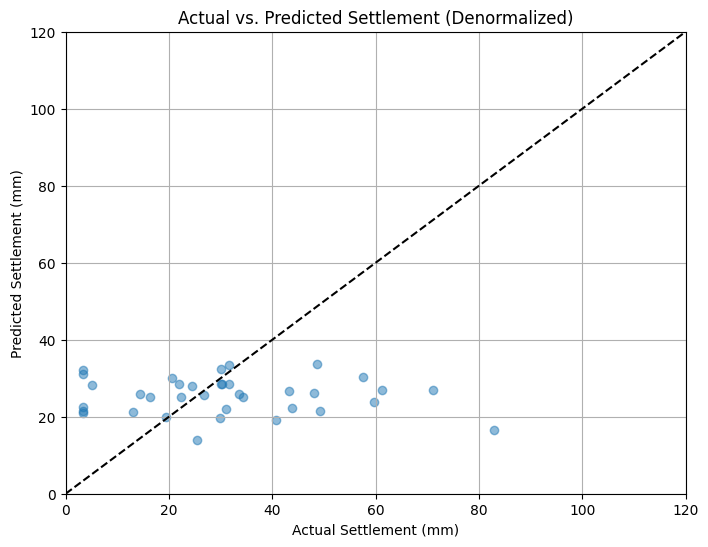

In [ ]:
# Compare results
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is the trained model from the previous cell (gmlHdxlXsoSM)
# Make predictions on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_settlement_normalized = model(X_test)

# Denormalize the predicted and actual settlement values
# Using the min and max values from output_stats DataFrame
output_min = output_stats[output_stats['Parameter Used'] == 'Sc']['Minimum'].iloc[0]
output_max = output_stats[output_stats['Parameter Used'] == 'Sc']['Maximum'].iloc[0]

predicted_settlement_denormalized = predicted_settlement_normalized.numpy() * (output_max - output_min) + output_min
actual_settlement_denormalized = y_test.numpy() * (output_max - output_min) + output_min


# Plot predicted vs actual settlement (Denormalized)
plt.figure(figsize=(8, 6))
plt.scatter(actual_settlement_denormalized, predicted_settlement_denormalized, alpha=0.5)
plt.xlabel("Actual Settlement (mm)")
plt.ylabel("Predicted Settlement (mm)")
plt.title("Actual vs. Predicted Settlement (Denormalized)")
plt.grid(True)

# Set axis limits
plt.xlim(0, 120)
plt.ylim(0, 120)

# Add 1:1 line
plt.plot([0, 120], [0, 120], color='black', linestyle='--')

plt.show()

In [ ]:
# compare to empirical prediction

# To get the indices from the test set produced by train_test_split before conversion to tensor,
# we can re-perform the split and store the indices.
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(normalized_input_df, normalized_output_df, test_size=0.2, random_state=42)

test_indices = X_test_df.index

# Get the original, denormalized test data using these indices
X_test_original = input_df.loc[test_indices]
y_test_original = output_df.loc[test_indices]

# Calculate empirical predictions for the test data
schultze_sherif_predictions = []
meyerhof_predictions = []
anagnostopoulus_predictions = []

for index, row in X_test_original.iterrows():
    N = row['Nc']
    B = row['B (m)']
    Df_B = row['Df/B']
    qnet = row['qnet (kPa)']

    # Handle potential None return from anagnostopoulus
    schultze_sherif_pred = schultze_sherif(qnet, N, Df_B)
    meyerhof_pred = meyerhof(qnet, N, Df_B)
    anagnostopoulus_pred = anagnostopoulus(qnet, N, B)

    # Append predictions, handling None values
    schultze_sherif_predictions.append(schultze_sherif_pred if schultze_sherif_pred is not None else np.nan)
    meyerhof_predictions.append(meyerhof_pred if meyerhof_pred is not None else np.nan)
    anagnostopoulus_predictions.append(anagnostopoulus_pred if anagnostopoulus_pred is not None else np.nan)


# Convert predictions to numpy arrays for plotting
schultze_sherif_predictions = np.array(schultze_sherif_predictions)
meyerhof_predictions = np.array(meyerhof_predictions)
anagnostopoulus_predictions = np.array(anagnostopoulus_predictions)

# Display the first few empirical predictions
print("Schultze and Sherif predictions (first 5):", schultze_sherif_predictions[:5])
print("Meyerhof predictions (first 5):", meyerhof_predictions[:5])
print("Anagnostopoulus predictions (first 5):", anagnostopoulus_predictions[:5])

Schultze and Sherif predictions (first 5): [ 1.04536169 33.02441161  5.40770067  2.70006018 19.01822192]
Meyerhof predictions (first 5): [ 0.85170221 30.18371428  4.65641557  1.38381365  8.73894019]
Anagnostopoulus predictions (first 5): [ 0.70209843 88.33897054 21.27750443  1.31091459  6.16412194]


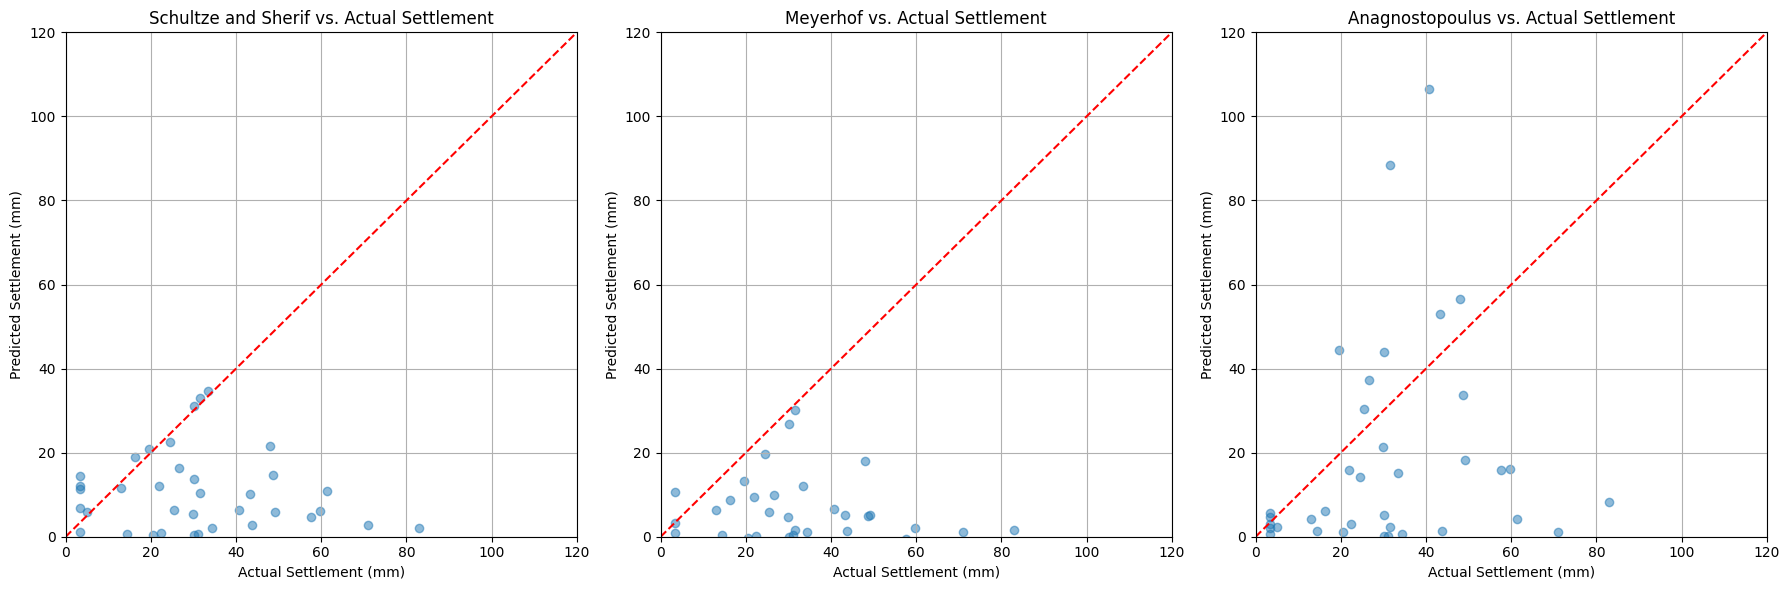

In [ ]:
# Plot empirical predictions vs actual settlement

plt.figure(figsize=(18, 6))

# Plot for Schultze and Sherif
plt.subplot(1, 3, 1)
plt.scatter(y_test_original.values, schultze_sherif_predictions, alpha=0.5)
plt.xlabel("Actual Settlement (mm)")
plt.ylabel("Predicted Settlement (mm)")
plt.title("Schultze and Sherif vs. Actual Settlement")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')


# Plot for Meyerhof
plt.subplot(1, 3, 2)
plt.scatter(y_test_original.values, meyerhof_predictions, alpha=0.5)
plt.xlabel("Actual Settlement (mm)")
plt.ylabel("Predicted Settlement (mm)")
plt.title("Meyerhof vs. Actual Settlement")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')

# Plot for Anagnostopoulus
plt.subplot(1, 3, 3)
plt.scatter(y_test_original.values, anagnostopoulus_predictions, alpha=0.5)
plt.xlabel("Actual Settlement (mm)")
plt.ylabel("Predicted Settlement (mm)")
plt.title("Anagnostopoulus vs. Actual Settlement")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')

plt.tight_layout()
plt.show()

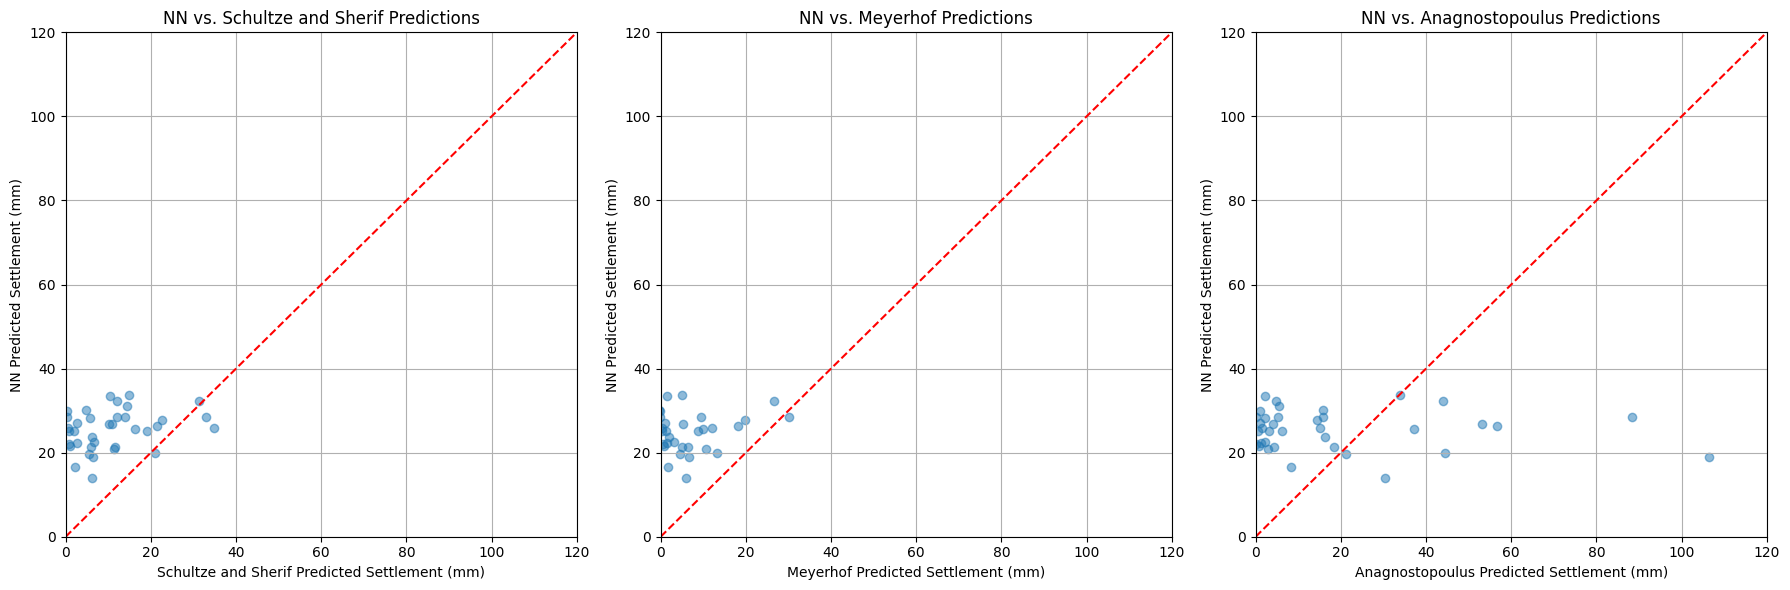

In [ ]:
# Plot NN predictions vs empirical predictions

plt.figure(figsize=(18, 6))

# Plot for NN vs Schultze and Sherif
plt.subplot(1, 3, 1)
plt.scatter(schultze_sherif_predictions, predicted_settlement_denormalized, alpha=0.5)
plt.xlabel("Schultze and Sherif Predicted Settlement (mm)")
plt.ylabel("NN Predicted Settlement (mm)")
plt.title("NN vs. Schultze and Sherif Predictions")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')


# Plot for NN vs Meyerhof
plt.subplot(1, 3, 2)
plt.scatter(meyerhof_predictions, predicted_settlement_denormalized, alpha=0.5)
plt.xlabel("Meyerhof Predicted Settlement (mm)")
plt.ylabel("NN Predicted Settlement (mm)")
plt.title("NN vs. Meyerhof Predictions")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')

# Plot for NN vs Anagnostopoulus
plt.subplot(1, 3, 3)
plt.scatter(anagnostopoulus_predictions, predicted_settlement_denormalized, alpha=0.5)
plt.xlabel("Anagnostopoulus Predicted Settlement (mm)")
plt.ylabel("NN Predicted Settlement (mm)")
plt.title("NN vs. Anagnostopoulus Predictions")
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.plot([0, 120], [0, 120], color='red', linestyle='--')


plt.tight_layout()
plt.show()

In [ ]:
# train model with predicted settlements from empirical equations

# Assuming the split was done on the pandas DataFrames, get the training indices
# from the original normalized input DataFrame before converting to tensors
# This assumes the order of rows is preserved during the train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(normalized_input_df, normalized_output_df, test_size=0.2, random_state=42)

train_indices = X_train_df.index

# Get the original, denormalized training data using these indices
X_train_original = input_df.loc[train_indices]

# Calculate empirical predictions for the training data
schultze_sherif_train_predictions = []
meyerhof_train_predictions = []
anagnostopoulus_train_predictions = []

for index, row in X_train_original.iterrows():
    N = row['Nc']
    B = row['B (m)']
    Df_B = row['Df/B']
    qnet = row['qnet (kPa)']

    # Handle potential None return from anagnostopoulus
    schultze_sherif_pred = schultze_sherif(qnet, N, Df_B)
    meyerhof_pred = meyerhof(qnet, N, Df_B)
    anagnostopoulus_pred = anagnostopoulus(qnet, N, B)

    # Append predictions, handling None values
    schultze_sherif_train_predictions.append(schultze_sherif_pred if schultze_sherif_pred is not None else np.nan)
    meyerhof_train_predictions.append(meyerhof_pred if meyerhof_pred is not None else np.nan)
    anagnostopoulus_train_predictions.append(anagnostopoulus_pred if anagnostopoulus_pred is not None else np.nan)


# Convert empirical predictions to numpy arrays
schultze_sherif_train_predictions = np.array(schultze_sherif_train_predictions)
meyerhof_train_predictions = np.array(meyerhof_train_predictions)
anagnostopoulus_train_predictions = np.array(anagnostopoulus_train_predictions)

# Normalize the empirical predictions
output_min = output_stats[output_stats['Parameter Used'] == 'Sc']['Minimum'].iloc[0]
output_max = output_stats[output_stats['Parameter Used'] == 'Sc']['Maximum'].iloc[0]

schultze_sherif_train_predictions_normalized = (schultze_sherif_train_predictions - output_min) / (output_max - output_min)
meyerhof_train_predictions_normalized = (meyerhof_train_predictions - output_min) / (output_max - output_min)
anagnostopoulus_train_predictions_normalized = (anagnostopoulus_train_predictions - output_min) / (output_max - output_min)


# Convert normalized empirical predictions to tensors
schultze_sherif_train_predictions_tensor = torch.tensor(schultze_sherif_train_predictions_normalized, dtype=torch.float32).unsqueeze(1)
meyerhof_train_predictions_tensor = torch.tensor(meyerhof_train_predictions_normalized, dtype=torch.float32).unsqueeze(1)
anagnostopoulus_train_predictions_tensor = torch.tensor(anagnostopoulus_train_predictions_normalized, dtype=torch.float32).unsqueeze(1)


# --- Train models using empirical predictions as target with different optimizers ---

epochs_empirical = 1000 # You can adjust the number of epochs
learn_rate_empirical = 0.01

empirical_targets = {
    "Schultze and Sherif": schultze_sherif_train_predictions_tensor,
    "Meyerhof": meyerhof_train_predictions_tensor,
    "Anagnostopoulus": anagnostopoulus_train_predictions_tensor
}

# Dictionaries to store models and evaluation results for each empirical target and optimizer
models_empirical_targets = {target_name: {} for target_name in empirical_targets.keys()}
rmse_results_empirical_targets = {target_name: {} for target_name in empirical_targets.keys()}
mae_results_empirical_targets = {target_name: {} for target_name in empirical_targets.keys()}
r2_results_empirical_targets = {target_name: {} for target_name in empirical_targets.keys()}


for target_name, y_train_empirical in empirical_targets.items():
    print(f"\n--- Training models with {target_name} predictions as target ---")
    for i in range(len(optimizers_to_test)):
        optimizer_name = optimizer_names[i]
        print(f"  Testing optimizer: {optimizer_name}")

        model = SandSettleNN(num_inputs=5, num_hidden_layers=1, width=2, activation=nn.Sigmoid(),
                             optimizer_class=optimizers_to_test[i], lr=learn_rate_empirical)
        criterion = nn.MSELoss()
        optimizer = model.optimizer

        for epoch in range(epochs_empirical):
            if optimizer_name == "LBFGS":
                def closure():
                    optimizer.zero_grad()
                    outputs = model(X_train) # Use the normalized X_train
                    loss = criterion(outputs, y_train_empirical)
                    loss.backward()
                    return loss
                lossMSE = optimizer.step(closure)
            else:
                optimizer.zero_grad()
                outputs = model(X_train) # Use the normalized X_train
                lossMSE = criterion(outputs, y_train_empirical)
                lossMSE.backward()
                optimizer.step()

            # Optional: Print loss every certain number of epochs
            # if (epoch + 1) % 100 == 0:
            #     print(f'    Epoch [{epoch+1}/{epochs_empirical}], Loss: {lossMSE.item():.4f}')

        # Store the trained model
        models_empirical_targets[target_name][optimizer_name] = model

        # Calculate evaluation metrics after training
        model.eval()
        with torch.no_grad():
            predicted_settlement_normalized = model(X_test)

        # Denormalize predictions for evaluation
        predicted_settlement_denormalized = predicted_settlement_normalized.numpy() * (output_max - output_min) + output_min

        rmse = np.sqrt(mean_squared_error(y_test_original.values, predicted_settlement_denormalized))
        mae = mean_absolute_error(y_test_original.values, predicted_settlement_denormalized)
        r2 = r2_score(y_test_original.values, predicted_settlement_denormalized)

        rmse_results_empirical_targets[target_name][optimizer_name] = rmse
        mae_results_empirical_targets[target_name][optimizer_name] = mae
        r2_results_empirical_targets[target_name][optimizer_name] = r2

print("\nTraining complete for all empirical targets and optimizers.")


--- Training models with Schultze and Sherif predictions as target ---
  Testing optimizer: SGD
  Testing optimizer: Adam
  Testing optimizer: Adadelta
  Testing optimizer: Adagrad
  Testing optimizer: LBFGS

--- Training models with Meyerhof predictions as target ---
  Testing optimizer: SGD
  Testing optimizer: Adam
  Testing optimizer: Adadelta
  Testing optimizer: Adagrad
  Testing optimizer: LBFGS

--- Training models with Anagnostopoulus predictions as target ---
  Testing optimizer: SGD
  Testing optimizer: Adam
  Testing optimizer: Adadelta
  Testing optimizer: Adagrad
  Testing optimizer: LBFGS

Training complete for all empirical targets and optimizers.



--- Plots for NN models trained with Schultze and Sherif predictions as target ---


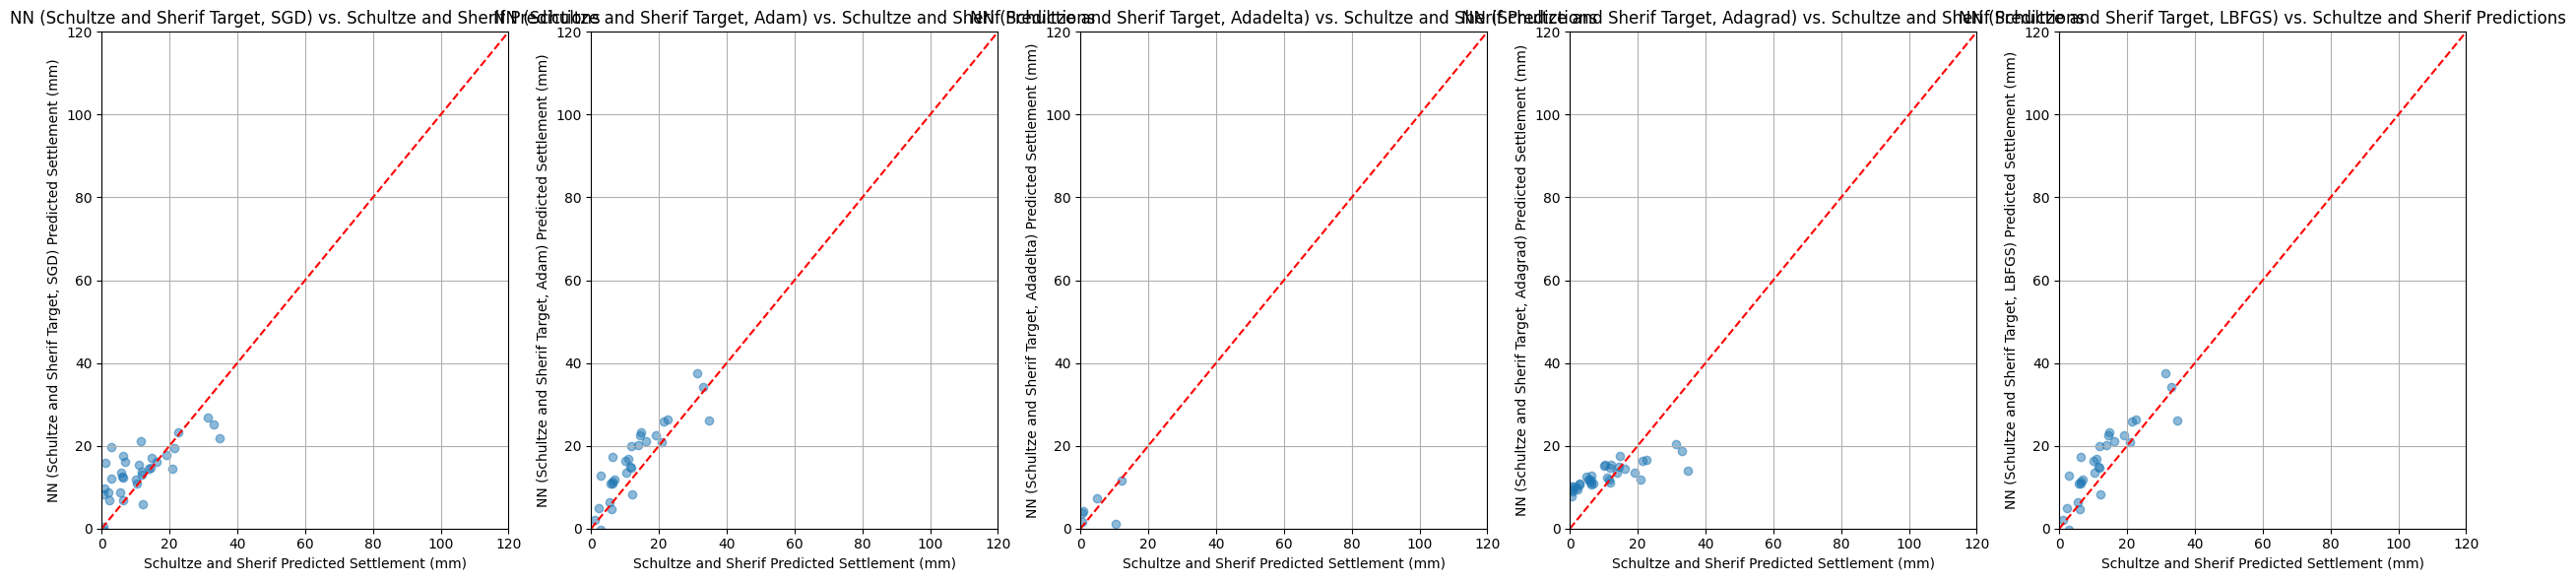


--- Plots for NN models trained with Meyerhof predictions as target ---


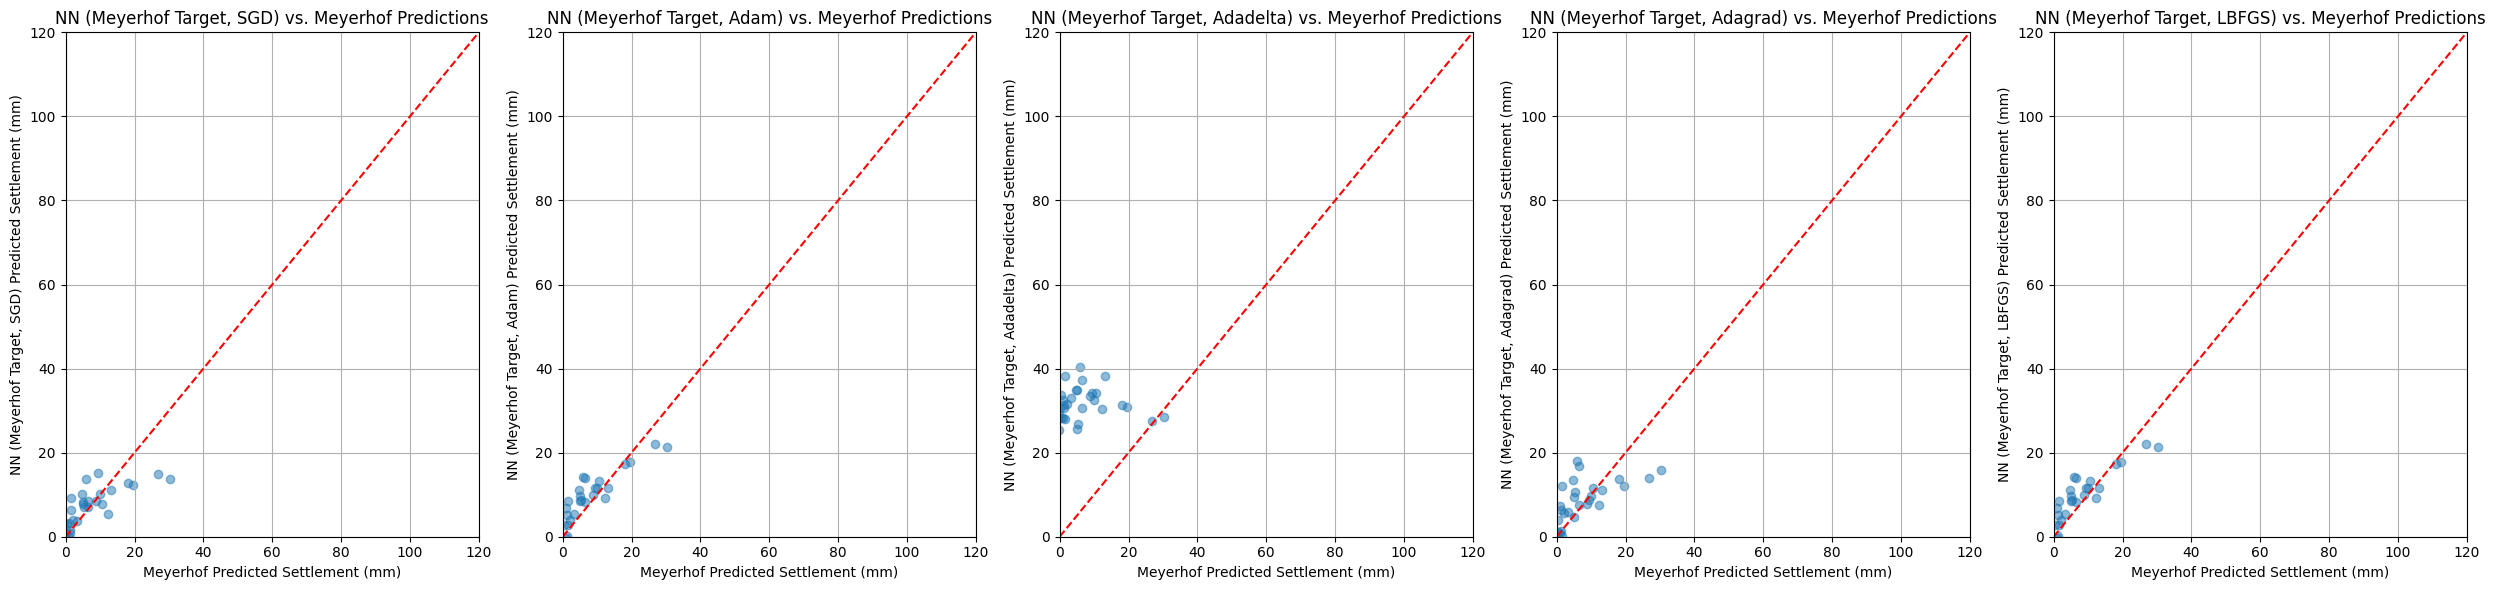


--- Plots for NN models trained with Anagnostopoulus predictions as target ---


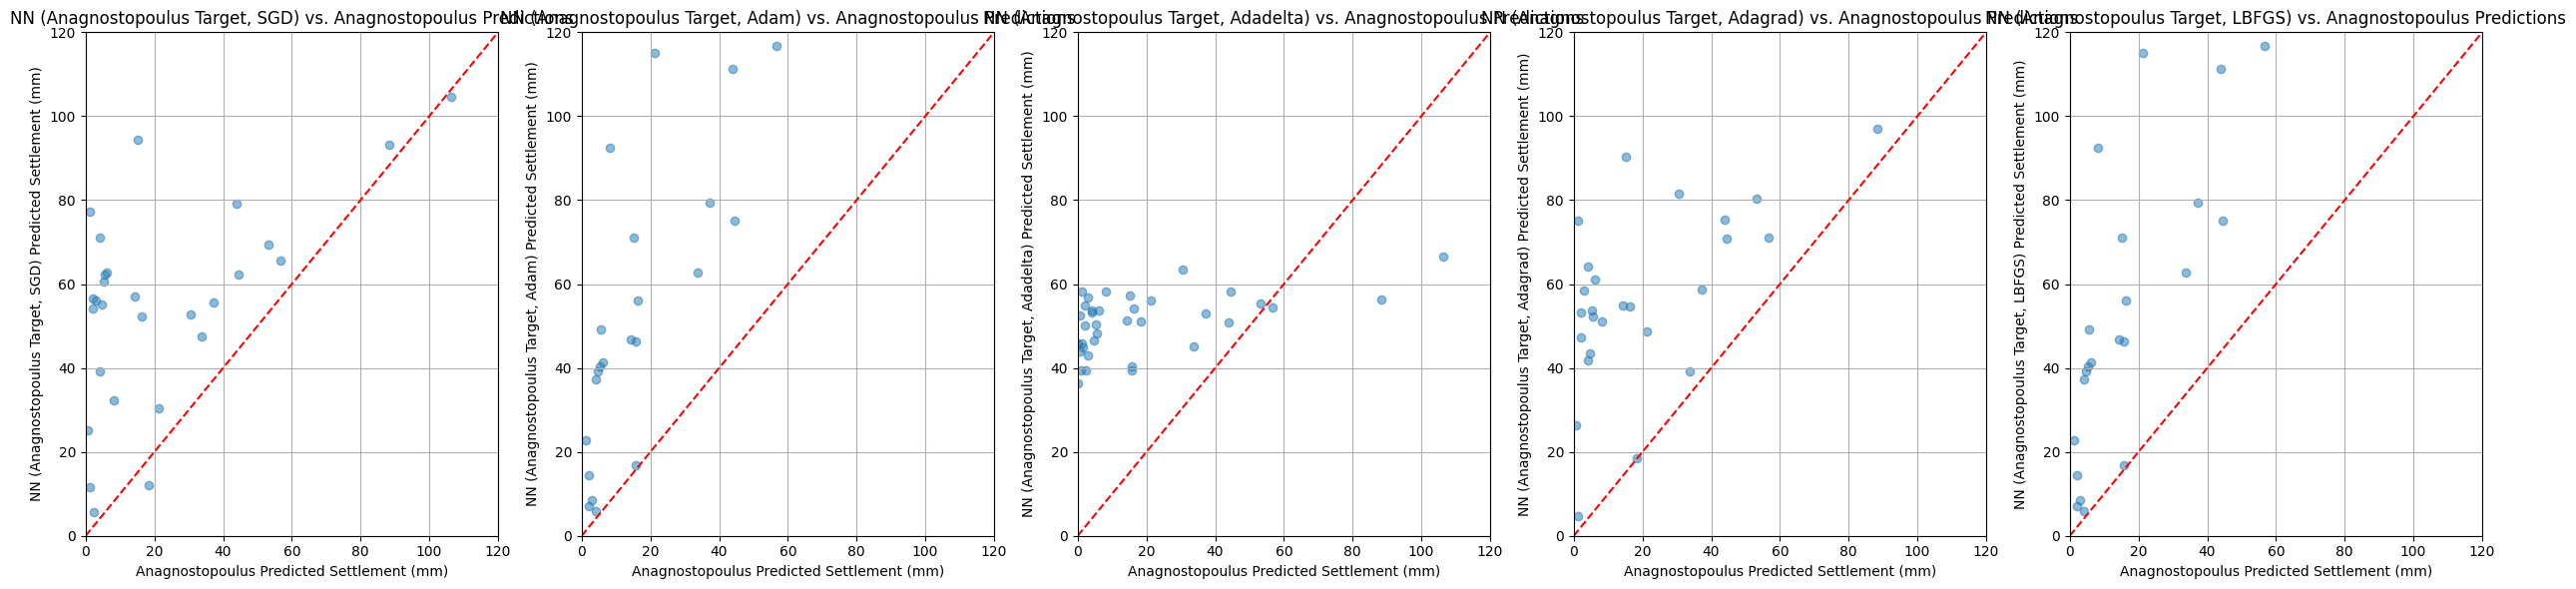

In [ ]:
# plot predictions based on empirical models for each optimizer

import matplotlib.pyplot as plt
import numpy as np

# Denormalize the predicted values from the models trained on empirical targets
output_min = output_stats[output_stats['Parameter Used'] == 'Sc']['Minimum'].iloc[0]
output_max = output_stats[output_stats['Parameter Used'] == 'Sc']['Maximum'].iloc[0]


# Define the empirical predictions for plotting
empirical_predictions_for_plotting = {
    "Schultze and Sherif": schultze_sherif_predictions,
    "Meyerhof": meyerhof_predictions,
    "Anagnostopoulus": anagnostopoulus_predictions
}

# Iterate through each empirical target and each optimizer to create plots
for target_name, empirical_preds in empirical_predictions_for_plotting.items():
    print(f"\n--- Plots for NN models trained with {target_name} predictions as target ---")
    plt.figure(figsize=(25, 6)) # Adjust figure size to accommodate more subplots

    for i in range(len(optimizers_to_test)):
        optimizer_name = optimizer_names[i]
        model = models_empirical_targets[target_name][optimizer_name]

        # Make predictions with the trained model
        model.eval()
        with torch.no_grad():
            predicted_settlement_normalized = model(X_test)

        # Denormalize the predicted values
        predicted_settlement_denormalized = predicted_settlement_normalized.numpy() * (output_max - output_min) + output_min

        # Plot for NN trained on empirical target vs empirical predictions
        plt.subplot(1, len(optimizers_to_test), i + 1) # Adjust subplot grid to 1 row and number of optimizers columns
        plt.scatter(empirical_preds, predicted_settlement_denormalized, alpha=0.5)
        plt.xlabel(f"{target_name} Predicted Settlement (mm)")
        plt.ylabel(f"NN ({target_name} Target, {optimizer_name}) Predicted Settlement (mm)")
        plt.title(f"NN ({target_name} Target, {optimizer_name}) vs. {target_name} Predictions")
        plt.grid(True)
        plt.xlim(0, 120)
        plt.ylim(0, 120)
        plt.plot([0, 120], [0, 120], color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Calculate evaluation metrics for Empirical Methods
rmse_empirical = {
    "Schultze and Sherif": np.sqrt(mean_squared_error(y_test_original.values, schultze_sherif_predictions)),
    "Meyerhof": np.sqrt(mean_squared_error(y_test_original.values, meyerhof_predictions)),
    "Anagnostopoulus": np.sqrt(mean_squared_error(y_test_original.values, anagnostopoulus_predictions))
}

mae_empirical = {
    "Schultze and Sherif": mean_absolute_error(y_test_original.values, schultze_sherif_predictions),
    "Meyerhof": mean_absolute_error(y_test_original.values, meyerhof_predictions),
    "Anagnostopoulus": mean_absolute_error(y_test_original.values, anagnostopoulus_predictions)
}

r2_empirical = {
    "Schultze and Sherif": r2_score(y_test_original.values, schultze_sherif_predictions),
    "Meyerhof": r2_score(y_test_original.values, meyerhof_predictions),
    "Anagnostopoulus": r2_score(y_test_original.values, anagnostopoulus_predictions)
}

# Combine results into a DataFrame
results_data = []

# Add results for the original NN (trained on generated data)
# Assuming the last trained model in the loop in gmlHdxlXsoSM is the one we want to report for the original NN
# You might want to explicitly store the best performing model based on validation loss or a specific optimizer
# For simplicity, we'll use the metrics calculated for each optimizer in gmlHdxlXsoSM
for optimizer_name in optimizer_names:
    results_data.append({
        "Model Type": "NN (Generated Data Target)",
        "Optimizer": optimizer_name,
        "RMSE": rmse_results[optimizer_name],
        "MAE": mae_results[optimizer_name],
        "R2": r2_results[optimizer_name]
    })

# Add results for Empirical Methods
for method_name in rmse_empirical.keys():
    results_data.append({
        "Model Type": "Empirical Method",
        "Optimizer": "N/A",
        "RMSE": rmse_empirical[method_name],
        "MAE": mae_empirical[method_name],
        "R2": r2_empirical[method_name]
    })

# Add results for NNs trained on Empirical Targets with different optimizers
for target_name in rmse_results_empirical_targets.keys():
    for optimizer_name in rmse_results_empirical_targets[target_name].keys():
        results_data.append({
            "Model Type": f"NN ({target_name} Target)",
            "Optimizer": optimizer_name,
            "RMSE": rmse_results_empirical_targets[target_name][optimizer_name],
            "MAE": mae_results_empirical_targets[target_name][optimizer_name],
            "R2": r2_results_empirical_targets[target_name][optimizer_name]
        })


results_df = pd.DataFrame(results_data)

# Display the table
display(results_df)

,Model Type,Optimizer,RMSE,MAE,R2
0,NN (Generated Data Target),SGD,0.205692,0.157105,-0.097026
1,NN (Generated Data Target),Adam,0.212702,0.160354,-0.173076
2,NN (Generated Data Target),Adadelta,0.294694,0.235003,-1.251769
3,NN (Generated Data Target),Adagrad,0.210194,0.158503,-0.145569
4,NN (Generated Data Target),LBFGS,0.212687,0.160343,-0.172910
5,Empirical Method,N/A,30.353075,22.582053,-1.384067
6,Empirical Method,N/A,33.220019,25.992708,-1.855702
7,Empirical Method,N/A,31.249936,23.450431,-1.527036
8,NN (Schultze and Sherif Target),SGD,28.125090,22.131106,-1.046920
9,NN (Schultze and Sherif Target),Adam,31.076152,24.038632,-1.499008


In [ ]:
# upload Appendix A data

from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# To read the uploaded CSV file into a pandas DataFrame:
# Replace 'your_uploaded_file.csv' with the actual name of the file you uploaded
df = pd.read_csv('AppendixA_csv.csv')
display(df.head())

Saving AppendixA_csv.csv to AppendixA_csv (5).csv
User uploaded file "AppendixA_csv (5).csv" with length 9513 bytes


,Reference,B (m),qnet (kPa),NSPT,L/B,Df/B,Sm (mm)
0,"Burland and Burbidge (1982, 1985)",15,0.8,1.0,0.00,78.0,7.0
1,"Burland and Burbidge (1982, 1985)",50,2.1,1.0,0.71,697.0,2.3
2,"Burland and Burbidge (1982, 1985)",60,2.5,3.8,1.20,284.0,1.0
3,"Burland and Burbidge (1982, 1985)",25,1.2,10.6,0.25,250.0,10.0
4,"Burland and Burbidge (1982, 1985)",20,0.9,1.0,3.44,300.0,6.7


In [ ]:
# prepare data for use from uploaded Appendix A

# Assuming the uploaded file is named 'AppendixA_csv.csv' and is in the content directory
file_path = 'AppendixA_csv.csv'

try:
    df_appendix_a = pd.read_csv(file_path)
    display(df_appendix_a.head())

    # Define input features (X) and target variable (y) from Appendix A
    # Note: Column names in Appendix A might differ slightly from generated data stats
    input_features_appendix = ['B (m)', 'qnet (kPa)', 'NSPT', 'L/B', 'Df/B']
    target_variable_appendix = 'Sm (mm)'


    # Check if required columns exist in the DataFrame
    if all(col in df_appendix_a.columns for col in input_features_appendix) and target_variable_appendix in df_appendix_a.columns:
        X_appendix_a = df_appendix_a[input_features_appendix]
        y_appendix_a = df_appendix_a[target_variable_appendix]

        # Convert to PyTorch tensors (original values)
        X_appendix_a_tensor_original = torch.tensor(X_appendix_a.values, dtype=torch.float32)
        y_appendix_a_tensor_original = torch.tensor(y_appendix_a.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for the single output

        # Check for NaN values in original tensors
        if torch.isnan(X_appendix_a_tensor_original).any():
            print("Warning: NaN values found in original X_appendix_a_tensor_original.")
        if torch.isnan(y_appendix_a_tensor_original).any():
             print("Warning: NaN values found in original y_appendix_a_tensor_original.")


        # Normalize the Appendix A data using the stats from the generated data
        # Map Appendix A column names to the names in input_stats/output_stats for normalization
        param_mapping = {
            'B (m)': 'B (m)',
            'qnet (kPa)': 'qnet (kPa)',
            'NSPT': 'Nc', # Map NSPT to Nc for normalization using input_stats
            'L/B': 'L/B',
            'Df/B': 'Df/B'
        }

        X_appendix_a_normalized = X_appendix_a_tensor_original.clone()
        for i, col_name in enumerate(input_features_appendix):
            param_name_for_stats = param_mapping.get(col_name, col_name) # Use mapped name, default to col_name
            # Fix: Use boolean indexing or .loc with column name to access stats
            min_val = input_stats.loc[input_stats['Parameter Used'] == param_name_for_stats, 'Minimum'].iloc[0]
            max_val = input_stats.loc[input_stats['Parameter Used'] == param_name_for_stats, 'Maximum'].iloc[0]
            X_appendix_a_normalized[:, i] = (X_appendix_a_tensor_original[:, i] - min_val) / (max_val - min_val)

        y_appendix_a_normalized = y_appendix_a_tensor_original.clone()
        # Fix: Use boolean indexing or .loc with column name to access stats
        # Map Sm (mm) to Sc for normalization using output_stats
        target_variable_for_stats = 'Sc'
        output_min = output_stats.loc[output_stats['Parameter Used'] == target_variable_for_stats, 'Minimum'].iloc[0]
        output_max = output_stats.loc[output_stats['Parameter Used'] == target_variable_for_stats, 'Maximum'].iloc[0]
        y_appendix_a_normalized[:, 0] = (y_appendix_a_tensor_original[:, 0] - output_min) / (output_max - output_min)


        # Assign the normalized tensors for training
        X_appendix_a_tensor = X_appendix_a_normalized
        y_appendix_a_tensor = y_appendix_a_normalized

        # Check for NaN values in normalized tensors
        if torch.isnan(X_appendix_a_tensor).any():
            print("Warning: NaN values found in normalized X_appendix_a_tensor.")
        if torch.isnan(y_appendix_a_tensor).any():
            print("Warning: NaN values found in normalized y_appendix_a_tensor.")

        print("\nAppendix A data loaded, normalized, and converted to PyTorch tensors:")
        print("X_appendix_a_tensor shape:", X_appendix_a_tensor.shape)
        print("y_appendix_a_tensor shape:", y_appendix_a_tensor.shape)
        print(f"Expected number of samples: {len(df_appendix_a)}")
        print(f"Number of samples in X_appendix_a_tensor: {X_appendix_a_tensor.shape[0]}")
        print(f"Number of samples in y_appendix_a_tensor: {y_appendix_a_tensor.shape[0]}")


    else:
        print(f"Error: One or more required columns not found in '{file_path}'.")
        print("Required columns:", input_features_appendix + [target_variable_appendix])
        print("Available columns:", df_appendix_a.columns.tolist())

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please ensure 'AppendixA_csv.csv' was uploaded.")
except Exception as e:
    print(f"An error occurred: {e}")

,Reference,B (m),qnet (kPa),NSPT,L/B,Df/B,Sm (mm)
0,"Burland and Burbidge (1982, 1985)",15,0.8,1.0,0.00,78.0,7.0
1,"Burland and Burbidge (1982, 1985)",50,2.1,1.0,0.71,697.0,2.3
2,"Burland and Burbidge (1982, 1985)",60,2.5,3.8,1.20,284.0,1.0
3,"Burland and Burbidge (1982, 1985)",25,1.2,10.6,0.25,250.0,10.0
4,"Burland and Burbidge (1982, 1985)",20,0.9,1.0,3.44,300.0,6.7



Appendix A data loaded, normalized, and converted to PyTorch tensors:
X_appendix_a_tensor shape: torch.Size([172, 5])
y_appendix_a_tensor shape: torch.Size([172, 1])
Expected number of samples: 172
Number of samples in X_appendix_a_tensor: 172
Number of samples in y_appendix_a_tensor: 172


In [ ]:
# train model with data from appendix using different optimizers

import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

epochs_appendix = 1000 # You can adjust the number of epochs
learn_rate_appendix = 0.01

# Assuming optimizers_to_test and optimizer_names are defined in a previous cell
# For example:
# optimizers_to_test = [optim.SGD, optim.Adam, optim.Adadelta, optim.Adagrad, optim.LBFGS]
# optimizer_names = ["SGD", "Adam", "Adadelta", "Adagrad", "LBFGS"]


# Dictionaries to store models and evaluation results for each optimizer on Appendix A data
models_appendix = {}
rmse_results_appendix = {}
mae_results_appendix = {}
r2_results_appendix = {}

print("Training models with Appendix A data using different optimizers...")

# Handle NaN values by removing rows with NaNs
nan_mask = torch.isnan(X_appendix_a_tensor).any(dim=1) | torch.isnan(y_appendix_a_tensor).any(dim=1)
X_appendix_a_tensor_cleaned = X_appendix_a_tensor[~nan_mask]
y_appendix_a_tensor_cleaned = y_appendix_a_tensor[~nan_mask]

if nan_mask.any():
    print(f"Removed {nan_mask.sum().item()} rows containing NaN values.")
    print(f"Remaining data shape: {X_appendix_a_tensor_cleaned.shape}")

for i in range(len(optimizers_to_test)):
    optimizer_name = optimizer_names[i]
    print(f"\n  Testing optimizer: {optimizer_name}")

    model = SandSettleNN(num_inputs=5, num_hidden_layers=1, width=2, activation=nn.Sigmoid(),
                         optimizer_class=optimizers_to_test[i], lr=learn_rate_appendix)
    criterion = nn.MSELoss()
    optimizer = model.optimizer

    loss_history_appendix = [] # Reset loss history for each optimizer

    for epoch in range(epochs_appendix):
        if optimizer_name == "LBFGS":
            def closure():
                optimizer.zero_grad()
                outputs = model(X_appendix_a_tensor_cleaned) # Use cleaned data for training
                loss = criterion(outputs, y_appendix_a_tensor_cleaned) # Use cleaned data for loss
                loss.backward()
                return loss
            lossMSE = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            outputs = model(X_appendix_a_tensor_cleaned) # Use cleaned data for training
            lossMSE = criterion(outputs, y_appendix_a_tensor_cleaned) # Use cleaned data for loss
            lossMSE.backward()
            optimizer.step()

        loss_history_appendix.append(lossMSE.item())

        # Optional: Print loss every certain number of epochs
        # if (epoch + 1) % 100 == 0:
        #     print(f'    Epoch [{epoch+1}/{epochs_appendix}], Loss: {lossMSE.item():.4f}')

    # Store the trained model
    models_appendix[optimizer_name] = model

    # Calculate evaluation metrics after training on the training data itself
    model.eval()
    with torch.no_grad():
        predicted_settlement = model(X_appendix_a_tensor_cleaned) # Evaluate on cleaned data

    # Convert tensors to numpy arrays and remove NaNs before calculating metrics
    y_true_np = y_appendix_a_tensor_cleaned.numpy()
    y_pred_np = predicted_settlement.numpy()

    # Find indices where neither y_true nor y_pred is NaN
    valid_indices = ~np.isnan(y_true_np).any(axis=1) & ~np.isnan(y_pred_np).any(axis=1)

    y_true_valid = y_true_np[valid_indices]
    y_pred_valid = y_pred_np[valid_indices]


    # Note: Denormalization is not needed here as the target data y_appendix_a_tensor_cleaned is normalized
    # If y_appendix_a_tensor_cleaned were not normalized, we would need to denormalize both predicted_settlement and y_appendix_a_tensor_cleaned
    # using the min/max from output_stats before calculating metrics.

   # rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
   # mae = mean_absolute_error(y_true_valid, y_pred_valid)
   # r2 = r2_score(y_true_valid, y_pred_valid)

    rmse_results_appendix[optimizer_name] = rmse
    mae_results_appendix[optimizer_name] = mae
    r2_results_appendix[optimizer_name] = r2

print("\nTraining complete for all optimizers on Appendix A data.")

# You can now access the trained models and evaluation metrics
# print("\nRMSE Results (Appendix A):", rmse_results_appendix)
# print("MAE Results (Appendix A):", mae_results_appendix)
# print("R2 Results (Appendix A):", r2_results_appendix)

Training models with Appendix A data using different optimizers...

  Testing optimizer: SGD

  Testing optimizer: Adam

  Testing optimizer: Adadelta

  Testing optimizer: Adagrad

  Testing optimizer: LBFGS

Training complete for all optimizers on Appendix A data.


--- Plots for NN models trained with Appendix A data ---


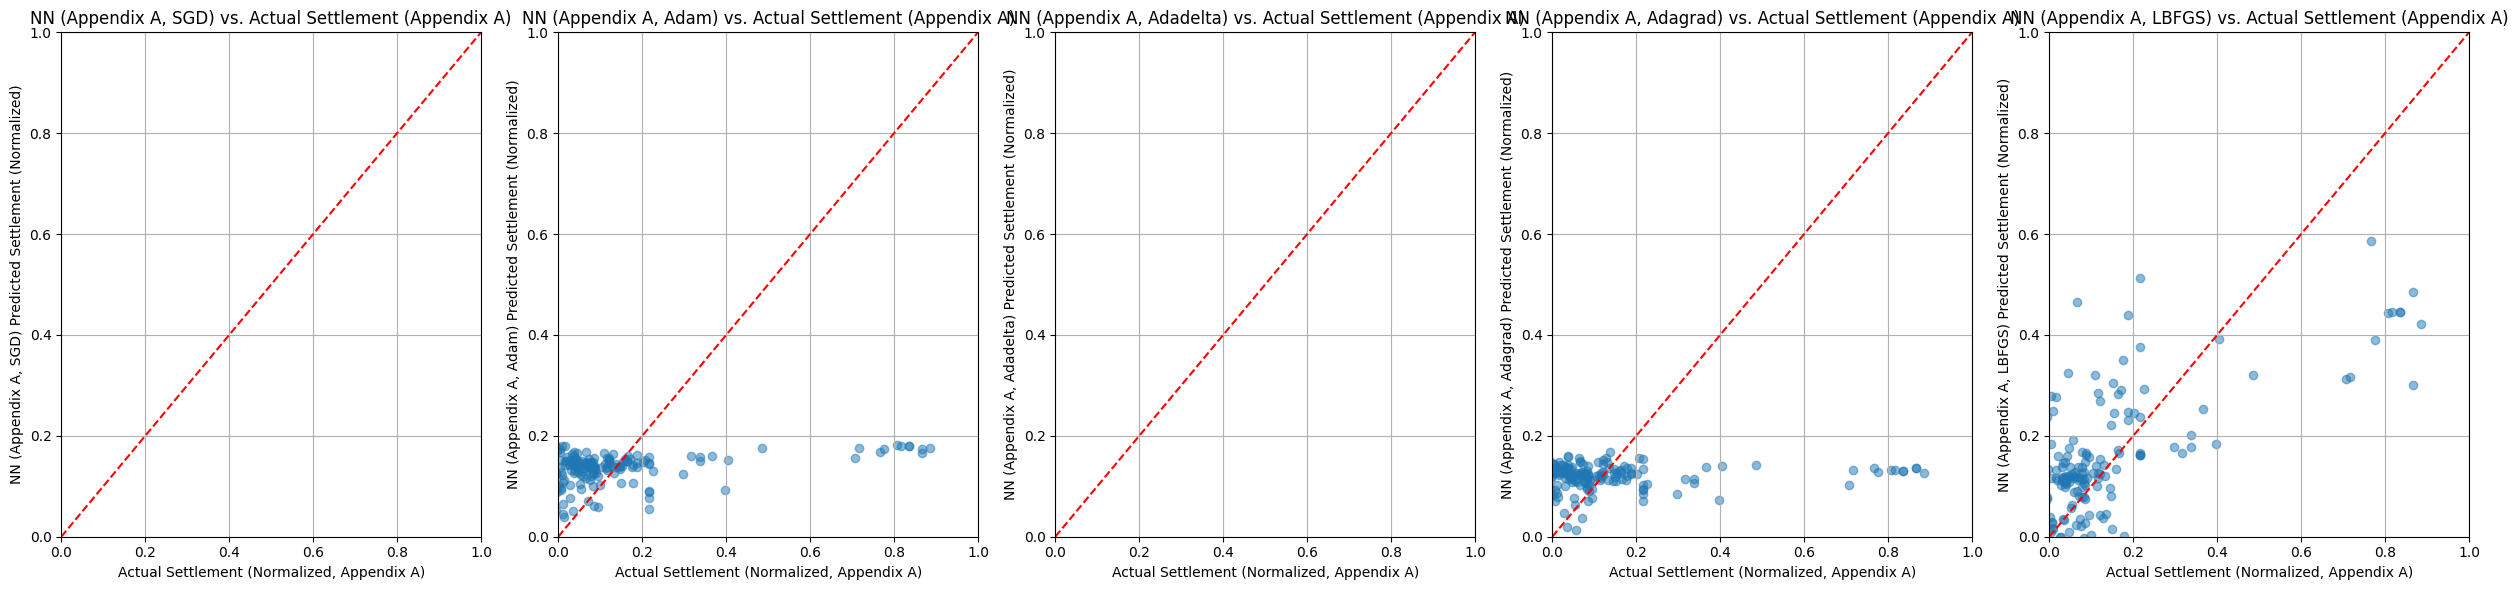

In [ ]:
# visualize data

import matplotlib.pyplot as plt
import numpy as np

# Assuming models_appendix and optimizers_to_test/optimizer_names are available from avNF1QBwrHfR
# Assuming X_appendix_a_tensor_cleaned and y_appendix_a_tensor_cleaned are available from avNF1QBwrHfR


print("--- Plots for NN models trained with Appendix A data ---")
plt.figure(figsize=(25, 6)) # Adjust figure size to accommodate plots for all optimizers

for i in range(len(optimizers_to_test)):
    optimizer_name = optimizer_names[i]
    model = models_appendix[optimizer_name]

    # Make predictions with the trained model on the cleaned Appendix A data
    model.eval()
    with torch.no_grad():
        predicted_settlement_normalized = model(X_appendix_a_tensor_cleaned)


    # Plot for NN trained on Appendix A data vs Actual Appendix A data
    plt.subplot(1, len(optimizers_to_test), i + 1) # Arrange plots in a row for each optimizer
    plt.scatter(y_appendix_a_tensor_cleaned.numpy(), predicted_settlement_normalized.numpy(), alpha=0.5)
    plt.xlabel("Actual Settlement (Normalized, Appendix A)")
    plt.ylabel(f"NN (Appendix A, {optimizer_name}) Predicted Settlement (Normalized)")
    plt.title(f"NN (Appendix A, {optimizer_name}) vs. Actual Settlement (Appendix A)")
    plt.grid(True)
    # Setting limits based on normalized data range [0, 1]
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')


plt.tight_layout()
plt.show()